In [1]:
import os
import sys
project_root = os.path.abspath("/blue/vabfmc/data/working/d.uriartediaz/francokrepel/project-root")
os.chdir(project_root)  # Change directory to project_root
print("Current working directory:", os.getcwd())

Current working directory: /blue/vabfmc/data/working/d.uriartediaz/francokrepel/project-root


In [21]:
import torch
import torch.nn.functional as F
#from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from src.models.graph_transformer_model import GraphTransformerModel
from src.data_processing.graph_dataset import GraphDataset

In [23]:
import pandas as pd
# loading slide labels and doinf labeling
metadata = pd.read_csv('data/BCC_labels.csv')  # Ensure this file contains 'slide_id' and 'label' columns

# Map labels to integers for binary classification
label_mapping = {
    'Clear': 0,
    'Present': 1
}
metadata['label'] = metadata['label'].map(label_mapping)

# Use 'StudyID #' as the grouping variable
# Ensure there are no missing values in 'StudyID #'
metadata = metadata.dropna(subset=['StudyID #'])
metadata['StudyID #'] = metadata['StudyID #'].astype(str)  # Convert to string if necessary

# Prepare data for splitting
X = metadata['slide_id']
y = metadata['label']
groups = metadata['StudyID #']  # Group by 'StudyID #'

# Split Data into Training and Test Sets
# Wel use StratifiedGroupKFold to ensure that the distribution of classes is maintained, and slides from the same study (patient) are not split between training and testing sets.
from sklearn.model_selection import StratifiedGroupKFold

n_splits = 5  # 5-fold cross-validation
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

splits = list(skf.split(X, y, groups))

# For demonstration, we'll use the first fold for training and testing
train_idx, test_idx = splits[0]
train_slide_ids = X.iloc[train_idx].tolist()
test_slide_ids = X.iloc[test_idx].tolist()

In [15]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model with appropriate dimensions
input_dim = 512  # Match with your input feature dimension
hidden_dim = 128  # Match with the hidden dimension used in training
num_classes = 2  # For binary classification: "Clear" vs "Present"

model = GraphTransformerModel(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
model.load_state_dict(torch.load("models/graph_transformer_final.pth"))  # Load the trained weights
model.to(device)
model.eval()

GraphTransformerModel(
  (gcn): GCNConv(512, 128)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [25]:
from torch_geometric.data import DataLoader
batch_size = 4
test_dataset = GraphDataset(root='data/graphs', slide_ids=test_slide_ids)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

/home/francokrepel/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Overall Test Accuracy: 0.5263


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/apps/pytorch/2.2.0/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/apps/pytorch/2.2.0/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/apps/pytorch/2.2.0/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/apps/pytorch/2.2.0/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/apps/pytorch/2.2.0/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/apps/pytorch/2.2.0/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/apps/pytorch/2.2.0/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    reader_close()
  File "/apps/pytorch/2.2.0/lib/pytho

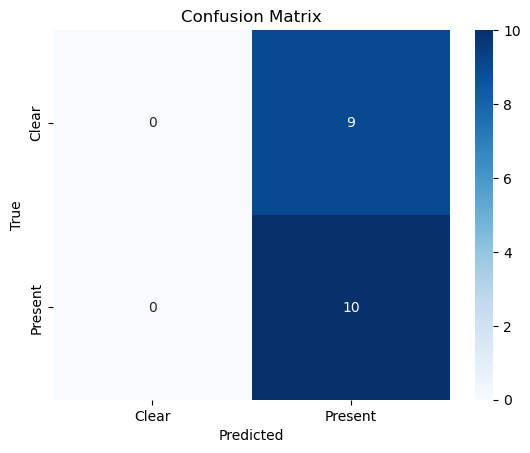

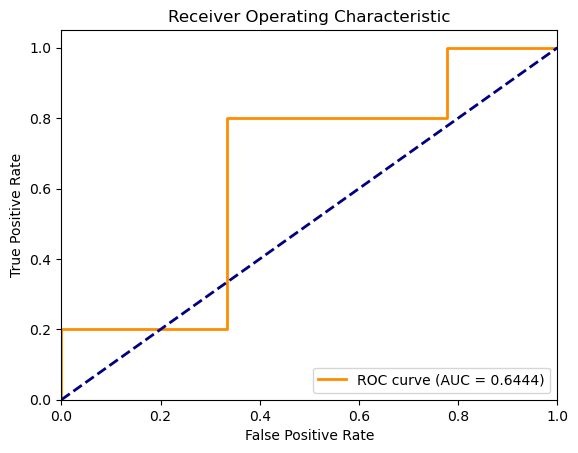

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to collect results
all_preds = []
all_labels = []
all_probs = []

# Evaluate on the test set
model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        probs = F.softmax(out, dim=1)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability for the "Present" class

# Calculate overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Test Accuracy: {accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clear', 'Present'], yticklabels=['Clear', 'Present'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
